## The Poisson's problem
The Poisson's problem is given as:
\begin{equation}
\begin{cases}
- \Delta u &= f, \quad x\in\Omega\\
       u & =0, \quad x\in\partial\Omega
\end{cases}
\end{equation}
where $\Omega=[0,1]^2$ and $f(x)=2\lambda^2 * \sin(\lambda x_1)*\sin(\lambda x_2)$ where $\lambda=4\pi$. It has explicit solution:
\begin{equation}
u(x) = \sin(\lambda x_1)*\sin(\lambda x_2).
\end{equation}

### (1) Prepare the training data

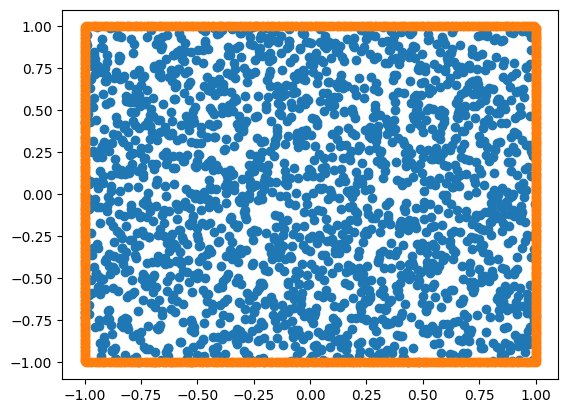

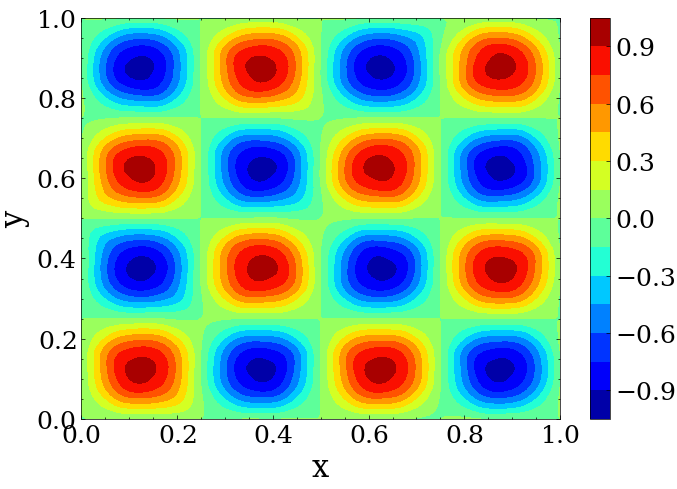

In [1]:
import sys 
sys.path.append("../..") 
import numpy as np
import torch 
import matplotlib.pyplot as plt
def setup_seed(seed):
     torch.manual_seed(seed)
     torch.cuda.manual_seed_all(seed)
     np.random.seed(seed)
     torch.backends.cudnn.deterministic = True

random_seed = 123
setup_seed(random_seed)
device = 'cuda:0'
dtype = torch.float32
problem_name = 'Poisson_2d'
######################################
# Setups of the problem 
######################################
from Utils.GenPoints import Point2D
from Problems.Poisson.Poisson_2d import Problem
problem = Problem(freq=4.*np.pi)
pointGen = Point2D(x_lb=problem._lb, x_ub=problem._ub, dataType=dtype, random_seed=random_seed)
#
N_center, N_bd_each_edge = 2000, 200
xc_train, R_train = pointGen.weight_centers(n_center=N_center, R_max=1e-4, R_min=1e-4)
x_bd_train = pointGen.boundary_point(num_each_edge=N_bd_each_edge, method='hypercube')
x_test = pointGen.inner_point(num_sample_or_mesh=25, method='mesh')
#########################################
plt.figure()
plt.scatter(xc_train[...,0], xc_train[...,1])
plt.scatter(x_bd_train[:,0], x_bd_train[:,1])
plt.show()
#######################################
from Utils.PlotFigure import Plot
u_test = problem._u_star(x_test)
Plot.show_2d(x_test, u_test)

### (2) Define the loss class

In [2]:
from torch.autograd import grad, Variable
from Utils.GenPoints import Point2D
from Utils.TestFun_ParticleWNN import TestFun_ParticleWNN
###############################
# The test function
###############################
int_grid, phi, dphi_dr = TestFun_ParticleWNN(
    fun_type='Wendland', dim=2, n_mesh_or_grid=9, 
    dataType=dtype).get_testFun()

######################################
## The mollifier (to satisfy the boundary condition)
######################################
class mollifer(object):

    def __inint__(self):
        super(mollifer, self).__init_()
        
    def __call__(self, u, grid):
        '''Define the mollifer
        '''
        x_mesh, y_mesh = grid[...,0:1], grid[...,1:2]
        u = u * torch.sin(np.pi * x_mesh)*torch.sin(np.pi * y_mesh)
        return u
    
##################################
##### The loss Class
##################################
class LossClass(object):

    def __init__(self, solver):
        super(LossClass, self).__init__()
        '''
        '''
        self.solver = solver
        self.mollifer = mollifer()
        self.dtype = solver.dtype
        self.device = solver.device
        self.model_u = solver.model_dict['u']
        ######################## 
        self.int_grid = int_grid.to(self.device)
        self.n_grid = int_grid.shape[0]
        self.v = phi.to(self.device)
        self.dv_dr = dphi_dr.to(self.device)
        
    def Loss_pde(self, xc=None, R=None):
        '''Define the PDE loss
        '''
        # ################################## 
        xc, R = pointGen.weight_centers(n_center=2000, R_max=1e-4, R_min=1e-4)
        xc, R = xc.to(self.device), R.to(self.device)
        ################################## The collocation points
        nc = xc.shape[0]
        x = self.int_grid * R + xc
        x = Variable(x.reshape(-1, 2), requires_grad=True)
        ##########################################
        v = self.v.repeat((nc,1,1)).reshape(-1,1)
        dv = (self.dv_dr / R).reshape(-1, 2)
        ##########################################
        u = self.model_u(x)
        if self.mollifer is not None:
            u = self.mollifer(u, x)
        du = grad(inputs=x, outputs=u, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        f = problem.fun_f(x)
        ###########################################
        right = torch.sum( (du * dv), dim=-1).reshape(nc, self.n_grid)
        right = torch.mean(right, dim=-1)
        #
        left = (f * v).reshape(nc, self.n_grid)
        left = torch.mean(left, dim=-1)
        ###########################################
        loss = self.solver.getLoss(left, right)
        
        return loss * 5.

    def Loss_bd(self):
        ''' '''
        if self.mollifer is None:
            x = Variable(x_bd_train, requires_grad=True).to(self.device)
            u, u_ = self.model_u(x), problem._u_star(x)
            #
            loss = self.solver.getLoss(u, u_)
        else:
            loss = torch.tensor(0., device=self.device)
        
        return loss * 2.
        
    def Error(self):
        ''' '''
        x = x_test.to(self.solver.device)
        u = u_test.to(self.solver.device)
        ####### 
        u_pred = self.model_u(x)
        if self.mollifer is not None:
            u_pred = self.mollifer(u_pred, x)
        #
        error = self.solver.getError(u_pred, u)

        return error

##########################################
from Solvers.ParticleWNN import ParticleWNN
#
solver = ParticleWNN.Solver(device, dtype=dtype)
model_u = solver.getModel([2, 40, 40, 40, 1], 'Tanh_Sin', netType='FCNet')

### (3) training and prediction

#### (3.1) Train the model

In [7]:
model_dict = {'u':model_u}
solver.train_setup(model_dict, lr=1e-3, optimizer='Adam', scheduler_type='StepLR', lbfgs=False, max_iter=1000)
solver.train(LossClass, xc_train, R_train, batch_size_in=int(xc_train.shape[0]/100), epochs=1000,
             epoch_show=10, **{'save_path':f'saved_models/'})
# solver.train_lbfgs(LossClass, xc, R, epochs=200, **{'save_path':f'saved_models/'})

  1%|▊                                                                               | 10/1000 [00:04<07:24,  2.23it/s]

Epoch:10 Time:4.7460, loss_in:2.433279, loss_bd:0.000000
          lr: 0.001 l2_err 0.032291803508996964


  2%|█▌                                                                              | 20/1000 [00:09<07:09,  2.28it/s]

Epoch:20 Time:9.1419, loss_in:1.605939, loss_bd:0.000000
          lr: 0.001 l2_err 0.0206860713660717


  3%|██▍                                                                             | 30/1000 [00:13<07:04,  2.28it/s]

Epoch:30 Time:13.5297, loss_in:1.261865, loss_bd:0.000000
          lr: 0.001 l2_err 0.017008783295750618


  4%|███▏                                                                            | 40/1000 [00:17<07:00,  2.28it/s]

Epoch:40 Time:17.9090, loss_in:1.397119, loss_bd:0.000000
          lr: 0.001 l2_err 0.021252857521176338


  5%|████                                                                            | 50/1000 [00:22<06:55,  2.28it/s]

Epoch:50 Time:22.2890, loss_in:1.604718, loss_bd:0.000000
          lr: 0.001 l2_err 0.018674015998840332


  6%|████▊                                                                           | 60/1000 [00:26<06:53,  2.27it/s]

Epoch:60 Time:26.7095, loss_in:1.089229, loss_bd:0.000000
          lr: 0.001 l2_err 0.01487755123525858


  7%|█████▌                                                                          | 70/1000 [00:31<06:47,  2.28it/s]

Epoch:70 Time:31.0904, loss_in:1.339099, loss_bd:0.000000
          lr: 0.001 l2_err 0.02390400320291519


  8%|██████▍                                                                         | 80/1000 [00:35<06:44,  2.28it/s]

Epoch:80 Time:35.4793, loss_in:1.072903, loss_bd:0.000000
          lr: 0.001 l2_err 0.017608873546123505


  9%|███████▏                                                                        | 90/1000 [00:39<06:39,  2.28it/s]

Epoch:90 Time:39.8619, loss_in:1.161569, loss_bd:0.000000
          lr: 0.001 l2_err 0.0175053458660841


 10%|███████▉                                                                       | 100/1000 [00:44<06:34,  2.28it/s]

Epoch:100 Time:44.2410, loss_in:0.964021, loss_bd:0.000000
          lr: 0.001 l2_err 0.01136869564652443


 11%|████████▋                                                                      | 110/1000 [00:48<06:29,  2.28it/s]

Epoch:110 Time:48.6292, loss_in:1.154055, loss_bd:0.000000
          lr: 0.001 l2_err 0.024203505367040634


 12%|█████████▍                                                                     | 120/1000 [00:53<06:25,  2.28it/s]

Epoch:120 Time:53.0208, loss_in:0.841357, loss_bd:0.000000
          lr: 0.001 l2_err 0.013935010880231857


 13%|██████████▎                                                                    | 130/1000 [00:57<06:21,  2.28it/s]

Epoch:130 Time:57.4059, loss_in:1.049544, loss_bd:0.000000
          lr: 0.001 l2_err 0.015073977410793304


 14%|███████████                                                                    | 140/1000 [01:01<06:17,  2.28it/s]

Epoch:140 Time:61.7970, loss_in:0.891810, loss_bd:0.000000
          lr: 0.001 l2_err 0.013872697949409485


 15%|███████████▊                                                                   | 150/1000 [01:06<06:12,  2.28it/s]

Epoch:150 Time:66.1845, loss_in:0.838390, loss_bd:0.000000
          lr: 0.001 l2_err 0.013976942747831345


 16%|████████████▋                                                                  | 160/1000 [01:10<06:08,  2.28it/s]

Epoch:160 Time:70.5730, loss_in:0.844384, loss_bd:0.000000
          lr: 0.001 l2_err 0.014124414883553982


 17%|█████████████▍                                                                 | 170/1000 [01:14<06:04,  2.28it/s]

Epoch:170 Time:74.9604, loss_in:0.812783, loss_bd:0.000000
          lr: 0.001 l2_err 0.009233471937477589


 18%|██████████████▏                                                                | 180/1000 [01:19<05:59,  2.28it/s]

Epoch:180 Time:79.3486, loss_in:0.811795, loss_bd:0.000000
          lr: 0.001 l2_err 0.01319519616663456


 19%|███████████████                                                                | 190/1000 [01:23<05:55,  2.28it/s]

Epoch:190 Time:83.7324, loss_in:0.893940, loss_bd:0.000000
          lr: 0.001 l2_err 0.016024772077798843


 20%|███████████████▊                                                               | 200/1000 [01:28<05:50,  2.28it/s]

Epoch:200 Time:88.1133, loss_in:0.994406, loss_bd:0.000000
          lr: 0.0005 l2_err 0.013001291081309319


 21%|████████████████▌                                                              | 210/1000 [01:32<05:46,  2.28it/s]

Epoch:210 Time:92.4982, loss_in:0.510154, loss_bd:0.000000
          lr: 0.0005 l2_err 0.005925598554313183


 22%|█████████████████▍                                                             | 220/1000 [01:36<05:42,  2.28it/s]

Epoch:220 Time:96.8848, loss_in:0.453957, loss_bd:0.000000
          lr: 0.0005 l2_err 0.006491661537438631


 23%|██████████████████▏                                                            | 230/1000 [01:41<05:38,  2.28it/s]

Epoch:230 Time:101.2767, loss_in:0.538698, loss_bd:0.000000
          lr: 0.0005 l2_err 0.0066071064211428165


 24%|██████████████████▉                                                            | 240/1000 [01:45<05:33,  2.28it/s]

Epoch:240 Time:105.6665, loss_in:0.485663, loss_bd:0.000000
          lr: 0.0005 l2_err 0.0073168352246284485


 25%|███████████████████▊                                                           | 250/1000 [01:50<05:29,  2.28it/s]

Epoch:250 Time:110.0530, loss_in:0.453426, loss_bd:0.000000
          lr: 0.0005 l2_err 0.0071992720477283


 26%|████████████████████▌                                                          | 260/1000 [01:54<05:24,  2.28it/s]

Epoch:260 Time:114.4445, loss_in:0.397886, loss_bd:0.000000
          lr: 0.0005 l2_err 0.009829871356487274


 27%|█████████████████████▎                                                         | 270/1000 [01:58<05:23,  2.25it/s]

Epoch:270 Time:118.8784, loss_in:0.500177, loss_bd:0.000000
          lr: 0.0005 l2_err 0.007929584942758083


 28%|██████████████████████                                                         | 280/1000 [02:03<05:16,  2.28it/s]

Epoch:280 Time:123.2661, loss_in:0.474311, loss_bd:0.000000
          lr: 0.0005 l2_err 0.008238845504820347


 29%|██████████████████████▉                                                        | 290/1000 [02:07<05:11,  2.28it/s]

Epoch:290 Time:127.6674, loss_in:0.455134, loss_bd:0.000000
          lr: 0.0005 l2_err 0.007011365611106157


 30%|███████████████████████▋                                                       | 300/1000 [02:12<05:07,  2.27it/s]

Epoch:300 Time:132.0585, loss_in:0.437521, loss_bd:0.000000
          lr: 0.0005 l2_err 0.007589910179376602


 31%|████████████████████████▍                                                      | 310/1000 [02:16<05:02,  2.28it/s]

Epoch:310 Time:136.4395, loss_in:0.486556, loss_bd:0.000000
          lr: 0.0005 l2_err 0.00802349578589201


 32%|█████████████████████████▎                                                     | 320/1000 [02:20<04:58,  2.28it/s]

Epoch:320 Time:140.8655, loss_in:0.467365, loss_bd:0.000000
          lr: 0.0005 l2_err 0.00871789176017046


 33%|██████████████████████████                                                     | 330/1000 [02:25<04:53,  2.28it/s]

Epoch:330 Time:145.2511, loss_in:0.541424, loss_bd:0.000000
          lr: 0.0005 l2_err 0.010662488639354706


 34%|██████████████████████████▊                                                    | 340/1000 [02:29<04:49,  2.28it/s]

Epoch:340 Time:149.6355, loss_in:0.424145, loss_bd:0.000000
          lr: 0.0005 l2_err 0.007646480575203896


 35%|███████████████████████████▋                                                   | 350/1000 [02:34<04:44,  2.28it/s]

Epoch:350 Time:154.0209, loss_in:0.479714, loss_bd:0.000000
          lr: 0.0005 l2_err 0.009310245513916016


 36%|████████████████████████████▍                                                  | 360/1000 [02:38<04:40,  2.28it/s]

Epoch:360 Time:158.4127, loss_in:0.544121, loss_bd:0.000000
          lr: 0.0005 l2_err 0.007381951902061701


 37%|█████████████████████████████▏                                                 | 370/1000 [02:42<04:36,  2.28it/s]

Epoch:370 Time:162.8056, loss_in:0.558171, loss_bd:0.000000
          lr: 0.0005 l2_err 0.006742979399859905


 38%|██████████████████████████████                                                 | 380/1000 [02:47<04:33,  2.27it/s]

Epoch:380 Time:167.2073, loss_in:0.387289, loss_bd:0.000000
          lr: 0.0005 l2_err 0.007982113398611546


 39%|██████████████████████████████▊                                                | 390/1000 [02:51<04:28,  2.27it/s]

Epoch:390 Time:171.6026, loss_in:0.490594, loss_bd:0.000000
          lr: 0.0005 l2_err 0.007092191372066736


 40%|███████████████████████████████▌                                               | 400/1000 [02:55<04:23,  2.28it/s]

Epoch:400 Time:175.9977, loss_in:0.355051, loss_bd:0.000000
          lr: 0.00025 l2_err 0.0061614662408828735


 41%|████████████████████████████████▍                                              | 410/1000 [03:00<04:20,  2.26it/s]

Epoch:410 Time:180.4063, loss_in:0.267920, loss_bd:0.000000
          lr: 0.00025 l2_err 0.005444624461233616


 42%|█████████████████████████████████▏                                             | 420/1000 [03:04<04:15,  2.27it/s]

Epoch:420 Time:184.8112, loss_in:0.314245, loss_bd:0.000000
          lr: 0.00025 l2_err 0.004233395680785179


 43%|█████████████████████████████████▉                                             | 430/1000 [03:09<04:11,  2.27it/s]

Epoch:430 Time:189.2263, loss_in:0.294401, loss_bd:0.000000
          lr: 0.00025 l2_err 0.0036600439343601465


 44%|██████████████████████████████████▊                                            | 440/1000 [03:13<04:06,  2.27it/s]

Epoch:440 Time:193.6526, loss_in:0.305303, loss_bd:0.000000
          lr: 0.00025 l2_err 0.005052709486335516


 45%|███████████████████████████████████▌                                           | 450/1000 [03:18<04:02,  2.27it/s]

Epoch:450 Time:198.0557, loss_in:0.299240, loss_bd:0.000000
          lr: 0.00025 l2_err 0.0052501969039440155


 46%|████████████████████████████████████▎                                          | 460/1000 [03:22<03:57,  2.27it/s]

Epoch:460 Time:202.4630, loss_in:0.309874, loss_bd:0.000000
          lr: 0.00025 l2_err 0.004537951201200485


 47%|█████████████████████████████████████▏                                         | 470/1000 [03:26<03:53,  2.27it/s]

Epoch:470 Time:206.8674, loss_in:0.261375, loss_bd:0.000000
          lr: 0.00025 l2_err 0.0037367597687989473


 48%|█████████████████████████████████████▉                                         | 480/1000 [03:31<03:50,  2.26it/s]

Epoch:480 Time:211.2828, loss_in:0.271504, loss_bd:0.000000
          lr: 0.00025 l2_err 0.005360017064958811


 49%|██████████████████████████████████████▋                                        | 490/1000 [03:35<03:44,  2.27it/s]

Epoch:490 Time:215.6909, loss_in:0.249338, loss_bd:0.000000
          lr: 0.00025 l2_err 0.004449805244803429


 50%|███████████████████████████████████████▌                                       | 500/1000 [03:40<03:40,  2.26it/s]

Epoch:500 Time:220.0964, loss_in:0.259248, loss_bd:0.000000
          lr: 0.00025 l2_err 0.0053701456636190414


 51%|████████████████████████████████████████▎                                      | 510/1000 [03:44<03:36,  2.27it/s]

Epoch:510 Time:224.5060, loss_in:0.295408, loss_bd:0.000000
          lr: 0.00025 l2_err 0.003323777811601758


 52%|█████████████████████████████████████████                                      | 520/1000 [03:48<03:30,  2.28it/s]

Epoch:520 Time:228.9055, loss_in:0.270045, loss_bd:0.000000
          lr: 0.00025 l2_err 0.004458179231733084


 53%|█████████████████████████████████████████▊                                     | 530/1000 [03:53<03:28,  2.25it/s]

Epoch:530 Time:233.3373, loss_in:0.256249, loss_bd:0.000000
          lr: 0.00025 l2_err 0.004385441541671753


 54%|██████████████████████████████████████████▋                                    | 540/1000 [03:57<03:22,  2.27it/s]

Epoch:540 Time:237.7402, loss_in:0.289250, loss_bd:0.000000
          lr: 0.00025 l2_err 0.004664822947233915


 55%|███████████████████████████████████████████▍                                   | 550/1000 [04:02<03:18,  2.26it/s]

Epoch:550 Time:242.1869, loss_in:0.274956, loss_bd:0.000000
          lr: 0.00025 l2_err 0.005516782868653536


 56%|████████████████████████████████████████████▏                                  | 560/1000 [04:06<03:11,  2.29it/s]

Epoch:560 Time:246.5717, loss_in:0.259353, loss_bd:0.000000
          lr: 0.00025 l2_err 0.005121980793774128


 57%|█████████████████████████████████████████████                                  | 570/1000 [04:10<03:10,  2.26it/s]

Epoch:570 Time:250.9278, loss_in:0.252449, loss_bd:0.000000
          lr: 0.00025 l2_err 0.004769442602992058


 58%|█████████████████████████████████████████████▊                                 | 580/1000 [04:15<03:00,  2.33it/s]

Epoch:580 Time:255.2289, loss_in:0.262814, loss_bd:0.000000
          lr: 0.00025 l2_err 0.003734508529305458


 59%|██████████████████████████████████████████████▌                                | 590/1000 [04:19<02:57,  2.31it/s]

Epoch:590 Time:259.5390, loss_in:0.266793, loss_bd:0.000000
          lr: 0.00025 l2_err 0.0042624506168067455


 60%|███████████████████████████████████████████████▍                               | 600/1000 [04:23<02:51,  2.33it/s]

Epoch:600 Time:263.8390, loss_in:0.250707, loss_bd:0.000000
          lr: 0.000125 l2_err 0.0044174278154969215


 61%|████████████████████████████████████████████████▏                              | 610/1000 [04:28<02:46,  2.34it/s]

Epoch:610 Time:268.1214, loss_in:0.206790, loss_bd:0.000000
          lr: 0.000125 l2_err 0.002989879110828042


 62%|████████████████████████████████████████████████▉                              | 620/1000 [04:32<02:43,  2.33it/s]

Epoch:620 Time:272.4243, loss_in:0.202645, loss_bd:0.000000
          lr: 0.000125 l2_err 0.0025266814045608044


 63%|█████████████████████████████████████████████████▊                             | 630/1000 [04:36<02:38,  2.33it/s]

Epoch:630 Time:276.7228, loss_in:0.202829, loss_bd:0.000000
          lr: 0.000125 l2_err 0.0026770406402647495


 64%|██████████████████████████████████████████████████▌                            | 640/1000 [04:41<02:37,  2.28it/s]

Epoch:640 Time:281.0728, loss_in:0.212536, loss_bd:0.000000
          lr: 0.000125 l2_err 0.0028076781891286373


 65%|███████████████████████████████████████████████████▎                           | 650/1000 [04:45<02:31,  2.31it/s]

Epoch:650 Time:285.4293, loss_in:0.214981, loss_bd:0.000000
          lr: 0.000125 l2_err 0.0029834886081516743


 66%|████████████████████████████████████████████████████▏                          | 660/1000 [04:49<02:25,  2.34it/s]

Epoch:660 Time:289.7090, loss_in:0.198684, loss_bd:0.000000
          lr: 0.000125 l2_err 0.0033158459700644016


 67%|████████████████████████████████████████████████████▉                          | 670/1000 [04:54<02:21,  2.32it/s]

Epoch:670 Time:294.0055, loss_in:0.221748, loss_bd:0.000000
          lr: 0.000125 l2_err 0.0029574811924248934


 68%|█████████████████████████████████████████████████████▋                         | 680/1000 [04:58<02:18,  2.30it/s]

Epoch:680 Time:298.3183, loss_in:0.194986, loss_bd:0.000000
          lr: 0.000125 l2_err 0.0034281027037650347


 69%|██████████████████████████████████████████████████████▌                        | 690/1000 [05:02<02:13,  2.32it/s]

Epoch:690 Time:302.6314, loss_in:0.206301, loss_bd:0.000000
          lr: 0.000125 l2_err 0.00352568831294775


 70%|███████████████████████████████████████████████████████▎                       | 700/1000 [05:06<02:08,  2.33it/s]

Epoch:700 Time:306.9351, loss_in:0.201094, loss_bd:0.000000
          lr: 0.000125 l2_err 0.0028516624588519335


 71%|████████████████████████████████████████████████████████                       | 710/1000 [05:11<02:04,  2.33it/s]

Epoch:710 Time:311.2284, loss_in:0.197422, loss_bd:0.000000
          lr: 0.000125 l2_err 0.0025036954320967197


 72%|████████████████████████████████████████████████████████▉                      | 720/1000 [05:15<02:02,  2.28it/s]

Epoch:720 Time:315.6060, loss_in:0.194607, loss_bd:0.000000
          lr: 0.000125 l2_err 0.0027934028767049313


 73%|█████████████████████████████████████████████████████████▋                     | 730/1000 [05:20<01:59,  2.26it/s]

Epoch:730 Time:320.0334, loss_in:0.203503, loss_bd:0.000000
          lr: 0.000125 l2_err 0.003196554724127054


 74%|██████████████████████████████████████████████████████████▍                    | 740/1000 [05:24<01:54,  2.27it/s]

Epoch:740 Time:324.4406, loss_in:0.185453, loss_bd:0.000000
          lr: 0.000125 l2_err 0.003146569710224867


 75%|███████████████████████████████████████████████████████████▎                   | 750/1000 [05:28<01:49,  2.29it/s]

Epoch:750 Time:328.8103, loss_in:0.187475, loss_bd:0.000000
          lr: 0.000125 l2_err 0.0029976917430758476


 76%|████████████████████████████████████████████████████████████                   | 760/1000 [05:33<01:45,  2.27it/s]

Epoch:760 Time:333.2128, loss_in:0.194990, loss_bd:0.000000
          lr: 0.000125 l2_err 0.003278701566159725


 77%|████████████████████████████████████████████████████████████▊                  | 770/1000 [05:37<01:40,  2.28it/s]

Epoch:770 Time:337.5988, loss_in:0.198780, loss_bd:0.000000
          lr: 0.000125 l2_err 0.0036383059341460466


 78%|█████████████████████████████████████████████████████████████▌                 | 780/1000 [05:42<01:36,  2.28it/s]

Epoch:780 Time:342.0304, loss_in:0.182537, loss_bd:0.000000
          lr: 0.000125 l2_err 0.0034389442298561335


 79%|██████████████████████████████████████████████████████████████▍                | 790/1000 [05:46<01:32,  2.28it/s]

Epoch:790 Time:346.4242, loss_in:0.199709, loss_bd:0.000000
          lr: 0.000125 l2_err 0.002952214563265443


 80%|███████████████████████████████████████████████████████████████▏               | 800/1000 [05:50<01:27,  2.29it/s]

Epoch:800 Time:350.7951, loss_in:0.203912, loss_bd:0.000000
          lr: 6.25e-05 l2_err 0.0029667664784938097


 81%|███████████████████████████████████████████████████████████████▉               | 810/1000 [05:55<01:23,  2.28it/s]

Epoch:810 Time:355.1719, loss_in:0.172396, loss_bd:0.000000
          lr: 6.25e-05 l2_err 0.0023502653930336237


 82%|████████████████████████████████████████████████████████████████▊              | 820/1000 [05:59<01:20,  2.25it/s]

Epoch:820 Time:359.5979, loss_in:0.166793, loss_bd:0.000000
          lr: 6.25e-05 l2_err 0.002674626652151346


 83%|█████████████████████████████████████████████████████████████████▌             | 830/1000 [06:03<01:14,  2.28it/s]

Epoch:830 Time:363.9920, loss_in:0.167994, loss_bd:0.000000
          lr: 6.25e-05 l2_err 0.00233017117716372


 84%|██████████████████████████████████████████████████████████████████▎            | 840/1000 [06:08<01:09,  2.29it/s]

Epoch:840 Time:368.3665, loss_in:0.176053, loss_bd:0.000000
          lr: 6.25e-05 l2_err 0.0023255019914358854


 85%|███████████████████████████████████████████████████████████████████▏           | 850/1000 [06:12<01:05,  2.28it/s]

Epoch:850 Time:372.7474, loss_in:0.160446, loss_bd:0.000000
          lr: 6.25e-05 l2_err 0.002501062350347638


 86%|███████████████████████████████████████████████████████████████████▉           | 860/1000 [06:17<01:01,  2.29it/s]

Epoch:860 Time:377.1210, loss_in:0.164170, loss_bd:0.000000
          lr: 6.25e-05 l2_err 0.0023397807963192463


 87%|████████████████████████████████████████████████████████████████████▋          | 870/1000 [06:21<00:57,  2.28it/s]

Epoch:870 Time:381.5417, loss_in:0.160436, loss_bd:0.000000
          lr: 6.25e-05 l2_err 0.002446278929710388


 88%|█████████████████████████████████████████████████████████████████████▌         | 880/1000 [06:25<00:52,  2.29it/s]

Epoch:880 Time:385.9201, loss_in:0.159981, loss_bd:0.000000
          lr: 6.25e-05 l2_err 0.0031432576943188906


 89%|██████████████████████████████████████████████████████████████████████▎        | 890/1000 [06:30<00:48,  2.29it/s]

Epoch:890 Time:390.2949, loss_in:0.166017, loss_bd:0.000000
          lr: 6.25e-05 l2_err 0.002426774939522147


 90%|███████████████████████████████████████████████████████████████████████        | 900/1000 [06:34<00:43,  2.28it/s]

Epoch:900 Time:394.6747, loss_in:0.164135, loss_bd:0.000000
          lr: 6.25e-05 l2_err 0.0024416842497885227


 91%|███████████████████████████████████████████████████████████████████████▉       | 910/1000 [06:39<00:39,  2.28it/s]

Epoch:910 Time:399.0612, loss_in:0.161547, loss_bd:0.000000
          lr: 6.25e-05 l2_err 0.0023749361280351877


 92%|████████████████████████████████████████████████████████████████████████▋      | 920/1000 [06:43<00:34,  2.31it/s]

Epoch:920 Time:403.4196, loss_in:0.163444, loss_bd:0.000000
          lr: 6.25e-05 l2_err 0.002460668794810772


 93%|█████████████████████████████████████████████████████████████████████████▍     | 930/1000 [06:47<00:30,  2.32it/s]

Epoch:930 Time:407.7366, loss_in:0.172082, loss_bd:0.000000
          lr: 6.25e-05 l2_err 0.002575166057795286


 94%|██████████████████████████████████████████████████████████████████████████▎    | 940/1000 [06:52<00:25,  2.32it/s]

Epoch:940 Time:412.0460, loss_in:0.162019, loss_bd:0.000000
          lr: 6.25e-05 l2_err 0.0024395284708589315


 95%|███████████████████████████████████████████████████████████████████████████    | 950/1000 [06:56<00:21,  2.32it/s]

Epoch:950 Time:416.3589, loss_in:0.165520, loss_bd:0.000000
          lr: 6.25e-05 l2_err 0.0027959581930190325


 96%|███████████████████████████████████████████████████████████████████████████▊   | 960/1000 [07:00<00:17,  2.28it/s]

Epoch:960 Time:420.7410, loss_in:0.157434, loss_bd:0.000000
          lr: 6.25e-05 l2_err 0.0025951722636818886


 97%|████████████████████████████████████████████████████████████████████████████▋  | 970/1000 [07:05<00:13,  2.28it/s]

Epoch:970 Time:425.1174, loss_in:0.161402, loss_bd:0.000000
          lr: 6.25e-05 l2_err 0.0025731229688972235


 98%|█████████████████████████████████████████████████████████████████████████████▍ | 980/1000 [07:09<00:08,  2.28it/s]

Epoch:980 Time:429.5007, loss_in:0.159150, loss_bd:0.000000
          lr: 6.25e-05 l2_err 0.002394460141658783


 99%|██████████████████████████████████████████████████████████████████████████████▏| 990/1000 [07:13<00:04,  2.28it/s]

Epoch:990 Time:433.8838, loss_in:0.160367, loss_bd:0.000000
          lr: 6.25e-05 l2_err 0.002293189289048314


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [07:18<00:00,  2.28it/s]

Epoch:1000 Time:438.2634, loss_in:0.152057, loss_bd:0.000000
          lr: 3.125e-05 l2_err 0.002525242744013667
The total training time is 438.2880


#### (3.2) Make prediction

The l2_err is tensor([0.0023])


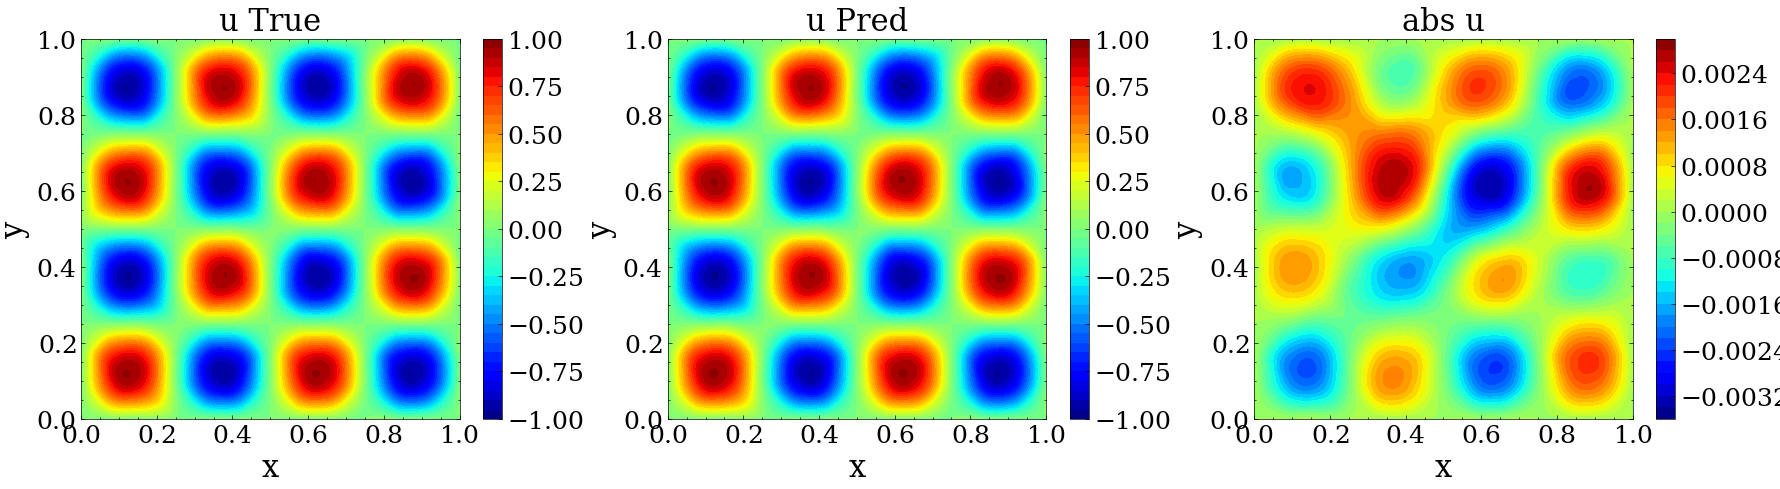

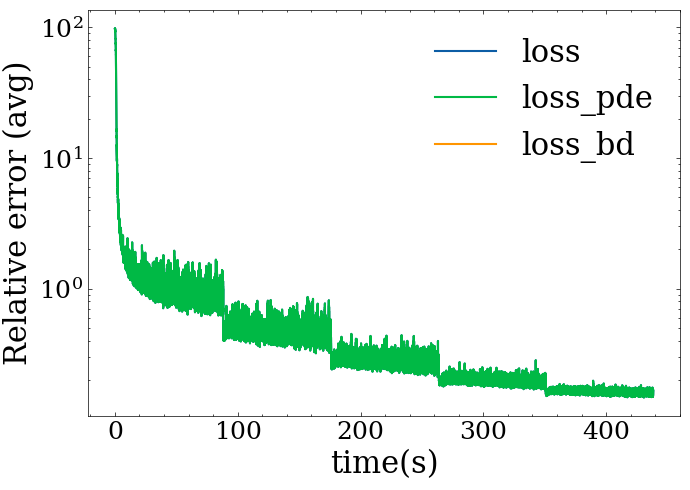

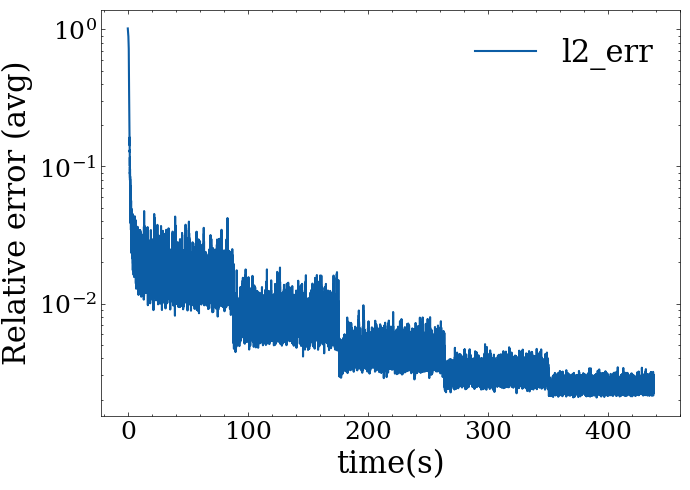

In [3]:
from Utils.PlotFigure import Plot
from Solvers.ParticleWNN import ParticleWNN
from Utils.Losses import * 
myerror = MyLoss().lp_rel
###############################
# load trained model
###############################
solver = ParticleWNN.Solver(device, dtype=dtype)
model_trained = solver.loadModel(path=f'saved_models/', name='model_particlewnn_final')

###############################
# make prediction
###############################
x_var = Variable(x_test, requires_grad=True).to(device)
u_var = model_trained['u'](x_var)
u_var = mollifer()(u_var, x_var)
#
du_var = grad(inputs=x_var, outputs=u_var, grad_outputs=torch.ones_like(u_var), create_graph=True)[0]
ux_var, uy_var = du_var[...,0:1].detach().cpu(), du_var[...,1:2].detach().cpu()
u_var = u_var.detach().cpu()
#
print('The l2_err is', myerror(u_var, u_test))

###############################
# show the result
###############################
Plot.show_2d_list(x_test, [u_test, u_var, u_test-u_var], ['u True', 'u Pred', 'abs u'])
##### show the loss
loss_saved = solver.loadLoss(path=f'saved_models/', name='loss_particlewnn')
Plot.show_error([loss_saved['time']]*3, 
                [loss_saved['loss'], loss_saved['loss_pde'], loss_saved['loss_bd']],
                ['loss', 'loss_pde', 'loss_bd'])
##### show the error
Plot.show_error([loss_saved['time']], [loss_saved['error']], ['l2_err'])